# BIOMEDIN 260/RAD260: Problem Set 3 - Mammogram Project

## Spring 2019

## Name 1:

Karina Samuel-Gama

## Name 2:

Areli Valencia

## Introduction

Breast cancer has the highest incidence and second highest mortality rate for women in the US.

Your task is to utilize machine learning to study mammograms in any way you want (e.g. classification, segmentation) as long as you justify why it is useful to do whatever it is you want to do. Turning in a deep dream assignment using mammograms might be amusing, for example, but not so useful to patients. That being said, choose something that interests you. As the adage goes, "do what you love, and you’ll never have to work another day in your life, at least in BMI 260."

Treat this as a mini-project. We highly encourage working with 1 other person, possibly someone in your main project team. 

In addition to the mammograms themselves, the dataset includes "ground-truth" segmentations and `mass_case_description_train_set.csv`, which contains metadata information about mass shapes, mass margins, assessment numbers, pathology diagnoses, and subtlety in the data. Take some time to research what all of these different fields mean and how you might utilize them in your work. You don't need to use all of what is provided to you.

Some ideas:

1. Use the ROI’s or segmentations to extract features, and then train a classifier based on those features using the algorithms presented to you in the machine learning lectures (doesn't need to use deep learning).

2. Use convolutional neural networks. Feel free to use any of the code we went over in class or use your own (custom code, sklearn, keras, Tensorflow etc.). If you dont want to place helper functions and classes into this notebook, place them in a `.py` file in the same folder called `helperfunctions.py` and import them into this notebook.

## Data

The data is here:

https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM

## Grading and Submission

This assignment has 3 components: code, figures (outputs/analyses of your code), and a write-up detailing your mini-project. You will be graded on these categories.

If you're OK with Python or R, please place all three parts into this notebook/.Rmd file that we have provided where indicated. We have written template sections for you to follow for simplicity/completeness. When you're done, save as a `.pdf` (please knit to `.pdf` if you are using `.Rmd`, or knit to `.html` and use a browser's "Print" function to convert to `.pdf`).

If you don't like Python OR R, we will allow you to use a different language, but please turn your assignment in with: 1) a folder with all your code, 2) a folder with all your figures, and 3) a `.tex`/`.doc`/`.pdf` file with a write-up.

## Title: Classification of Benign and Malignant Breast Lesions

In [13]:
import os
import cv2
import skimage

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import mahotas as mt
import seaborn as sn

from PIL import Image 
from skimage import io 
from sklearn.model_selection import train_test_split
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border 
from skimage.morphology import remove_small_objects 
from skimage.morphology import binary_closing
from skimage.measure import label
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

**1. Describe what you are doing and why it matters to patients using at least one citation.**

Breast cancer has the highest incidence and is the second most common cause of cancer deaths among women.1 Since there are no effective ways to prevent breast cancer, there is a need for efficient diagnosis of breast cancer in its early stages to provide the best prognosis for patients.2 One of the most effective methods for detection of breast cancer is through mammography because it provides high-quality images at a low radiation dose.3 However, the mammography images often have low contrast, which makes it difficult for radiologists to interpret.3 Previous studies have shown that mammography studies are susceptible to a high rate of false positives as well as false negatives, causing either further unnecessary clinical evaluation or failure to detect early signs of a malignant tumor.4,5 

An early sign of disease is a breast mass but it can be benign or malignant. There are several features that can be used to differentiate between a benign and malignant tumors. For example, benign tumors tend to have round or oval shapes, whereas malignant tumors have partially rounded shape with irregular borders.6 Furthermore, malignant masses may appear whiter than any surrounding tissue.3 Several studies have developed computer aided detection algorithms that have improved sensitivity of detecting breast cancer.3,6 Therefore, there is a need for effective detection algorithms to prevent breast cancer associated morbidity and mortality. Our objective is to utilize images from the publicly available Curated Breast Imaging Subset of the Digital Database for Screening Mammography (DDSM) dataset to train an algorithm that will classify whether a mass is benign or malignant. 

We will be using a random forest model on extracted texture and shape features on breast mammographs to automaticlaly detect wether a patient has a probabilty for a malignant tumor

**2. Describe the relevant statistics of the data. How were the images taken? How were they labeled? What is the class balance and majority classifier accuracy? How will you divide the data into testing, training and validation sets?**

In [243]:
df = pd.read_csv("./metadata_semijoin_labels.csv")
print "There are " + str(len(df)) + " unique images with the following subset breakdown\n" + str(df.nunique()) + "\nand the following calss balance \n" + str(df['label'].value_counts())

There are 1508 unique images with the following subset breakdown
id       800
side       2
view       2
label      2
dtype: int64
and the following calss balance 
0    786
1    722
Name: label, dtype: int64


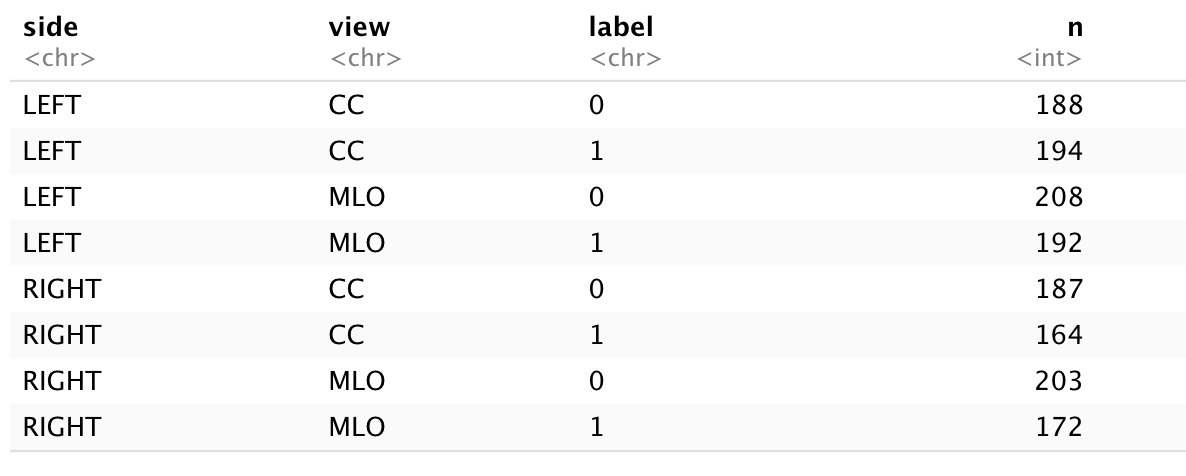

Images were downloaded from the DDSM, which is a collection of 2,620 cases from the following hospitals: Massachusetts General Hospital, Wake Forest University School of Medicine, Sacred Heart Hospital, and Washington University of St Louis School of Medicine. All images in the DDSM were derived from several different scanners, so they were standardized and re-mapped to a 16-bit grayscale TIFF files as described by Lee et al.7 Scans were labeled either benign or malignant based on pathology verification.7 This dataset consist of 1508 breast mammography images that are either craniocaudal (CC) or mediolateral oblique (MLO) views. There were no duplicate labels in the dataset. There were equal numbers of positive and negative images in the dataset with a majority classifier accuracy of ~52%. The images were stratified based on side of breast (right or left), image view (CC or MLO), and label (benign or malignant) resulting in eight different groups each consisting of ~190 images. This even proportion minimizes any training artifacts. Data was split into a 70%, 20%, and 10% datasets to create the training, development, and test sets using scikit-learn train_test_split function. 

**3. Describe your data pipeline (how is the data scrubbed, normalized, stored, and fed to the model for training?).**

Since the images were taken on different scanner, the starting values pixel values may fall on a very wide range despite similar image appearance. To address this, images were mean normalized using z-score standardization, then scaled from 0 to 1 using min-max normalization. After normalization, images were segmented using Otsu's method, filtered and smoothed using binary closing. Given that malignancy of tumor is determined by shape and texture - after preprocessing, 7 Hu Moment shape features and 13 of the Haralick texture features were extracted from each image. These 20 features will be fed into a random forest model.

In [196]:
def normalizeImages(orig_img): 
    # Resize image to 750 x 375
    resize_img = cv2.resize(orig_img, dsize = (375,750), interpolation=cv2.INTER_NEAREST)
    resize_img = resize_img.astype('float32')
    
    # Mean standardize with z score and shift to positive domain
    zscale_img = stats.zscore(resize_img, axis=None)
    shift_img = np.add(zscale_img, np.nanmin(zscale_img))

    # Normalize images using max-min
    normalize_img = np.divide(np.subtract(shift_img, np.nanmin(shift_img)),
                              np.subtract(np.nanmax(shift_img ), np.nanmin(shift_img)))
    return normalize_img 

def segmentAndSmooth(normalize_img): 
    #Otsu's Threshold 
    oned_img = normalize_img.ravel()
    nonzero_oned = oned_img[oned_img > 0]
    thresh = threshold_otsu(nonzero_oned)
    # Smoothing Image
    image = normalize_img > thresh 
    labeled_img = skimage.measure.label(image, neighbors=8)
    filtered_img = remove_small_objects(labeled_img, min_size=575, connectivity=2)
    smoothed_img = binary_closing(filtered_img)
    # Create segmented Image
    segmented_img = normalize_img.copy()
    segmented_img[smoothed_img == 0] = np.nan 
    return segmented_img 

def featureExtraction(segmented_img): 
    features = []
    numeric_img = np.nan_to_num(segmented_img)
    int_img = np.multiply(numeric_img, 255).astype('int')
    # Texture Extraction
    textures = mt.features.haralick(int_img)
    ht_mean = textures.mean(axis=0)
    # HU_moments Extraction 
    hu_moments = cv2.HuMoments(cv2.moments(numeric_img)).flatten()
    features = np.concatenate([hu_moments,ht_mean])
    return features

[ 3.06896454e-01  2.37273580e-02  1.03329291e-02  1.10572221e-03
 -5.66833183e-07 -9.95603077e-05  3.69426298e-06  5.26555538e-01
  4.77512174e+01  9.95706084e-01  5.56033180e+03  7.86330242e-01
  8.82242042e+01  2.21935760e+04  3.02478748e+00  3.93512246e+00
  2.20094235e-03  1.68325791e+00 -5.58439593e-01  9.75949702e-01]


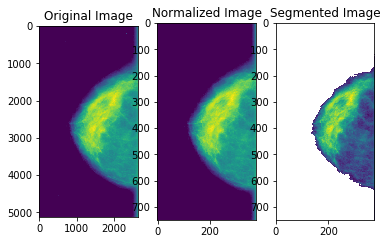

In [197]:
# Test Case of one image
scan_path = "/Users/ksamgam/Downloads/breast_mg/P_00032_RIGHT_CC.tif"
image = io.imread(scan_path)
    
normalizedImg = normalizeImages(image)
smoothedImg = segmentAndSmooth(normalizedImg)
features = featureExtraction(smoothedImg)

print features

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.set_title('Original Image')
ax2.set_title('Normalized Image')
ax3.set_title('Segmented Image')

ax1.imshow(image)
ax2.imshow(normalizedImg)
ax3.imshow(smoothedImg)

**4. Explain how the model you chose works alongside the code for it. Add at least one technical citation to give credit where credit is due.**

For binary classification of the 1) the presence of lesions in breast tissue and 2) the classification of lesion as malignant or benign we have chosen to use a random forest classfier. Supervised random forest classifiers work by randomly subsetting the data and features and building decision trees on each of these subsets. Random forests work by ensembling single decsion trees that work with only a subset of the data and features. For each decision tree, each node represents a split on a feature (categorical or continuous) that maximizes purity of the child nodes. Purity is a measure of percentage of a single class represented at each node. In random forests, hundreds of trees are built out and the output is probability of an observation belonging to a class computed by taking the average prediction for an observation across all trees in the model. 8

Random forest are especially useful in medical imaging because they offer high interpretability of the weights used to make classfication. Each feature is assigned an importance, with features leading to better performace being given a higher importance, meaning after trainign we can se which of the 20 features explained most of the classfication accuracy. Another benefit of random forests is that they are scalable with larger datasets and sparse feature spaces. This means that features can be easily added to the model with relatively low addition of computational time. 9

Given the above advantages, random forests classifiers have seen an increase in use over support vector machines. 9. They ahve show improved accruacy over baseline models when used in conjunction with extracted feature sets like texture features, shape features, and local bianry patterms. 9, 10.

In [241]:
# Create matrix of observations and features
image_names = pd.read_csv("./image_names.csv")
scans_path = "/Users/ksamgam/Downloads/breast_mg" 
list_of_scans = image_names['X1'].values.tolist()

num_of_scans = len(list_of_scans)
allData = np.zeros((20,num_of_scans))

for scan_num in range(len(list_of_scans)):
    scan_path = os.path.join(scans_path, list_of_scans[scan_num])
    image = io.imread(scan_path)
    
    normalizedImg = normalizeImages(image)
    smoothedImg = segmentAndSmooth(normalizedImg)
    features = featureExtraction(smoothedImg)
    
    allData[:,scan_num] = features

np.savetxt("features.csv", allData, delimiter=",")

In [3]:
# Creat Training, dev and test set
features = pd.read_csv("./features.csv", header = None).T
labels = pd.read_csv("metadata_semijoin_labels.csv")
X_train, X_test, y_train, y_test = train_test_split(features, labels["label"], test_size=0.3)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.33)

In [ ]:
{'bootstrap': [True, False],
 'max_depth': [5, 8 , 10, 15],
 'max_features': [None, 'sqrt'],
 'n_estimators': [100 250 500 750 100]}

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2)
rf_random.fit(X_train, y_train

In [8]:
# Train random forest classifier and predict class
clf = RandomForestClassifier(n_estimators=1000, max_depth=5, criterion = "gini", max_features = None)
pred = clf.fit(X_train, y_train).predict(X_dev)

In [10]:
cm = confusion_matrix(y_dev, pred)
cm

array([[113,  48],
       [ 94,  48]])

Iterate using values of confusion_matrix

**5. There are many ways to do training. Take us through how you do it (e.g. "We used early stopping and stopped when validation loss increased twice in a row.").**

In order to get the best performance from our model we modified three key 4 key parameters of the random forest classifier - number of estimators (how many trees are used), max_depth (how many splits per tree), criterion (how to judge the quality of split), and max_features(how many features to consider at each tree). 

Increasing number of estimators tended to result in increase in dev performance but caused overfitting and increased computation time. We tuned max depth to prevent any overfitting that we noticed. We used gini as our criterion because entropy has often be used as a good measure of separation for binary classification problems. The most difficult parameter to judge the effect of was max_features. we chose max_features = n_features because sqrt and log both gave feature choice of ~4.5 which was very small given the amount of variability (750x375 pixels) per image

Given these initial estimates, we used gridCV to select our final parameters for our model

**6. Make a figure displaying your results.**

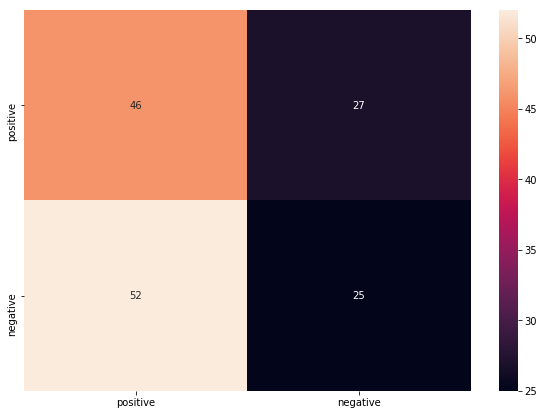

In [17]:
pred = clf.fit(X_train, y_train).predict(X_test)
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index = ["positive", "negative"],
                  columns = ["positive", "negative"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

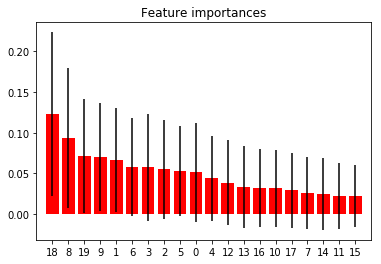

In [20]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The classifier did worse than the majority class accuracy with most of the error resulting from false negatives. Looking at the feature importance of the random forest model we see that the top three features are 18 (info. measure of correlation 1), 8 (contrast), and 19 (info measure of correlation 2). One thing to note is these are all texture features, shape features make up ranks 5 - 11 

**7. Discuss pros and cons of your method and what you might have done differently now that you've tried or would try if you had more time.**

One major con flaw in the process was only normalizing images within each image instead of across all images in the dataset. This was done partly as oversight and partly because of lack of computational power. This may have affected the amount of informatione encoded by the 20 extracted features - since we took the mean of the images (for the texture features) comparison of means between positive and negative labels that have not been normalized against each other might not be valid. In order to improve performance we would redo normalization. Additional, areas of improvements could be to use local binary patterns as they are some of the newest feature sets to be created.

Pros of using this method is quick trainign time (collapsing sparse multidimensional space in to smaller feature set) and interpretability of results.

**You will not be graded on the performance of your model. You'll only be graded on the scientific soundness of your claims, methodology, evaluation (i.e. fair but insightful statistics), and discussion of the strengths and shortcomings of what you tried. Feel free to reuse some of the code you are/will be using for your projects. The write-up doesn't need to be long (~1 page will suffice), but please cite at least one clinical paper and one technical paper (1 each in questions 1 and 4 at least, and more if needed).**

References
1. 	DeSantis CE, Ma J, Goding Sauer A, Newman LA, Jemal A. Breast cancer statistics, 2017, racial disparity in mortality by state. CA Cancer J Clin. 2017;67(6):439-448.
2. 	Harding C, Pompei F, Burmistrov D, Welch HG, Abebe R, Wilson R. Breast Cancer Screening, Incidence, and Mortality Across US Counties. JAMA Intern Med. 2015;175(9):1483-1489.
3. 	Tang J, Rangayyan RM, Xu J, El Naqa I, Yang Y. Computer-aided detection and diagnosis of breast cancer with mammography: recent advances. IEEE Trans Inf Technol Biomed. 2009;13(2):236-251.
4. 	Bird RE, Wallace TW, Yankaskas BC. Analysis of cancers missed at screening mammography. Radiology. 1992;184(3):613-617.
5. 	Kerlikowske K, Carney PA, Geller B, et al. Performance of screening mammography among women with and without a first-degree relative with breast cancer. Ann Intern Med. 2000;133(11):855-863.
6. 	Ragab DA, Sharkas M, Marshall S, Ren J. Breast cancer detection using deep convolutional neural networks and support vector machines. PeerJ. 2019;7:e6201.
7. 	Lee RS, Gimenez F, Hoogi A, Miyake KK, Gorovoy M, Rubin DL. A curated mammography data set for use in computer-aided detection and diagnosis research. Sci Data. 2017;4:170177.
8. Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.
9. Ko, B. C., Kim, S. H., & Nam, J. Y. (2011). X-ray image classification using random forests with local wavelet-based CS-local binary patterns. Journal of digital imaging, 24(6), 1141-1151.
10. Man, W., Ji, Y., & Zhang, Z. (2018, April). Image classification based on improved random forest algorithm. In 2018 IEEE 3rd International Conference on Cloud Computing and Big Data Analysis (ICCCBDA) (pp. 346-350). IEEE.